In [37]:
import os

import numpy as np
import pandas as pd

import glob

import time
from tqdm import tqdm

import librosa
import librosa.display
import soundfile as sf # librosa fails when reading files on Kaggle.


import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [38]:
file_names = glob.glob("./AnnotatedAudioFiles/*.wav")
file_names = sorted(file_names)

In [39]:
print(file_names)

['./AnnotatedAudioFiles/code0_dating-violence_01.wav', './AnnotatedAudioFiles/code0_dating-violence_02.wav', './AnnotatedAudioFiles/code0_dating-violence_03.wav', './AnnotatedAudioFiles/code0_dating-violence_04.wav', './AnnotatedAudioFiles/code0_dating-violence_05.wav', './AnnotatedAudioFiles/code0_dating-violence_06.wav', './AnnotatedAudioFiles/code0_dating-violence_07.wav', './AnnotatedAudioFiles/code0_dating-violence_08.wav', './AnnotatedAudioFiles/code0_dating-violence_09.wav', './AnnotatedAudioFiles/code0_dating-violence_10.wav', './AnnotatedAudioFiles/code0_dating-violence_11.wav', './AnnotatedAudioFiles/code0_dating-violence_12.wav', './AnnotatedAudioFiles/code0_dating-violence_13.wav', './AnnotatedAudioFiles/code0_dating-violence_14.wav', './AnnotatedAudioFiles/code0_dating-violence_15.wav', './AnnotatedAudioFiles/code0_dating-violence_16.wav', './AnnotatedAudioFiles/code0_dating-violence_17.wav', './AnnotatedAudioFiles/code0_dating-violence_18.wav', './AnnotatedAudioFiles/code

In [40]:
to_df = []
for f in file_names:
    tmp = f.split('/')[2].split('_')[1]
    to_df.append([f, tmp])

In [41]:
tmp_df = pd.DataFrame(to_df, columns=['path', 'situation'])

In [42]:
tmp_df['situation'].value_counts()

robber              207
candid cam          197
normal              183
candid-cam          160
crying-man          140
crying-woman        132
dating-violence      90
flasher              74
inebriate-woman      70
disorder-man         60
inebriated woman     50
disorder             44
violence             37
disorder-woman       32
rape                 31
office-violence      25
inebriate-man        25
invasion             24
injury               23
drunken woman        22
inebriated man       19
sponsor              15
drunken man          12
Name: situation, dtype: int64

In [43]:
situation_id = [i for i in range(0,23)]
situation_name = list(tmp_df['situation'].unique())
situation_code = {v:k for k,v in zip(situation_id, situation_name)}
print(situation_code)

{'dating-violence': 0, 'injury': 1, 'office-violence': 2, 'rape': 3, 'robber': 4, 'sponsor': 5, 'violence': 6, 'candid cam': 7, 'candid-cam': 8, 'disorder-man': 9, 'disorder-woman': 10, 'disorder': 11, 'drunken man': 12, 'drunken woman': 13, 'flasher': 14, 'inebriate-man': 15, 'inebriate-woman': 16, 'inebriated man': 17, 'inebriated woman': 18, 'invasion': 19, 'crying-man': 20, 'crying-woman': 21, 'normal': 22}


In [44]:
to_df = []
for f in file_names:
    tmp = f.split('/')[2].split('_')[1]
    to_df.append([f, tmp, situation_code[tmp]])

In [45]:
to_df

[['./AnnotatedAudioFiles/code0_dating-violence_01.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_02.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_03.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_04.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_05.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_06.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_07.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_08.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_09.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_10.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_11.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_12.wav', 'dating-violence', 0],
 ['./AnnotatedAudioFiles/code0_dating-violence_13.wa

In [46]:
df = pd.DataFrame(to_df, columns=['path', 'situation', 'label'])

In [47]:
df

,path,situation,label
0,./AnnotatedAudioFiles/code0_dating-violence_01...,dating-violence,0
1,./AnnotatedAudioFiles/code0_dating-violence_02...,dating-violence,0
2,./AnnotatedAudioFiles/code0_dating-violence_03...,dating-violence,0
3,./AnnotatedAudioFiles/code0_dating-violence_04...,dating-violence,0
4,./AnnotatedAudioFiles/code0_dating-violence_05...,dating-violence,0
...,...,...,...
1667,./AnnotatedAudioFiles/code5_normal_3(time9000t...,normal,22
1668,./AnnotatedAudioFiles/code5_normal_3(time900to...,normal,22
1669,./AnnotatedAudioFiles/code5_normal_3(time9300t...,normal,22
1670,./AnnotatedAudioFiles/code5_normal_3(time9600t...,normal,22


In [48]:
def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 

def get_audios():
    train_file_names = df['path']
    samples = []
    for file_name in tqdm(train_file_names):
        x, sr = sf.read(file_name, always_2d=True)
        if not len(x) == 0:
            x = parse_audio(x)
            samples.append(mean_mfccs(x))
        else:
            print(file_name)
    return np.array(samples)

def get_samples():
    return get_audios(), df['label'].values

In [49]:
X, Y = get_samples()

# Since the data manufacturer doesn't provide the labels for the test audios,
# we will have do the split for the labeled data.
x_train, x_test, y_train, y_test = train_test_split(X, Y)

100%|██████████| 1672/1672 [07:02<00:00,  3.96it/s]


In [50]:
X[1]

array([-223.23847344,  159.63898117,  -42.04055463,   39.69304541,
        -22.00238026,   -1.74652697,    7.55648021,  -28.78402535,
         14.09620984,   -9.13239067,  -10.90585218,    3.24076042,
        -13.13769685,    3.25023464,   -8.27890307,   -6.29741216,
          4.19891044,   -6.21407779,    1.67575477,   -4.58692045])

In [51]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [52]:
print(f'Model Score: {model.score(x_test, y_test)}')

y_predict = model.predict(x_test)
print(f'Confusion Matrix: \n{confusion_matrix(y_predict, y_test)}')

Model Score: 0.916267942583732
Confusion Matrix: 
[[22  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 52  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  3  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 

In [53]:
type(confusion_matrix(y_predict, y_test))

numpy.ndarray

In [54]:
print(y_predict.shape)
print(y_test.shape)

(418,)
(418,)


In [55]:
print(y_predict)

[ 6 14 16  0  0  4  8 20  6 22 11  4 16 22 15  4 16 13  4 20 21  7  7  4
 15 21 20  2  9  7  0 21  7 22 10  8  8 22 20  7 10  4  8 16 21 14  7  9
  7  4  7  4 18 20  3  4 21  8 22 14  7 14 11 22  7 10  4 22  9  7  8  6
 18  4  8  9 22  9 19  4  4 19  7  4  8  4 22 21  7  7  8 14 20  7 22 20
 11  4 16  0 15 21 21 14 14 16  7  6 20  0 22 22  2  4  0 19  8  4  7  8
 22  4 21 22 22 11  0 22  4  4  0  7 20 15  8  7  0  7  6  6  4 22  6 14
  8 18  1  6  7 21  1 20 22  2 19  8 21  7  0  8 20 20 21  3 21  7  7  8
 18 20  8 16  8  8 21 11 10  9 21  4  8 20  1  7  7 20 16  9 22 16  4  4
 20 20 19  7  8  4 22 20 22  8 11  8  5 16  7  4  0 14 20 21 20 22 22 16
 20 21 17 21  4 21 11  0 11  7  4  4 14 14  4 15  7 20 22 20  4 22  8 22
 22 22  9  0  7 22 11  7 22 22 22  0  0 20 11 21  4 19  7  0  0  4  4 21
 21  7  8 18 22 19  7  7  9  4  7  4 14 20 20 11 21  0 22  6  7 10 20 15
  8  4  9  7  4  4  7 14 14 10  6 13 20 16 15  1  4  7  4  8  7 18 17  7
 20  0  8  7 20 22  8  2 14  8 22 14  8  4 20 14  8

In [56]:
print(y_test)

[ 6 14 16  4  0  4  8 20  6 22 11  4 16 22 15  4 16 21  4 20 21  7  7  4
 15 21 20  2  9  7  0 21  7 22 10  8  8 22 20  7 10  4  8 16 21 14  7  9
  7  4  7  4 17 20  3  4 21  8 22 11  7 14 11 22  7 10  4 22  9  7  8  6
 18  4  8  9 22  9 21  4 20 19  7  4  8  4 22 21  7  7  8  7 20  7 22  9
 18  4 16  0 16 21 21 14 20 16 18  6 20  4 22 22  2  4  0 19  3  4  7  8
 22  4 21 22 22 14  0 22  4  4  0  7 20 15  8  7  0  7 21  6  4 22  6 14
  8 18  1  6  7 21  1 20 22  2 19  3 21  7  0  8 20 20 21  3 21 18  7  8
 18 20  8 16  8  8 21 11 10  9 21  4  3 20  1  7  7 20 16  9 22 16  4 21
 20 20 19  7  8  4 22 20 22  8 11  8  5 16  7  4  0 14 20 21 20 22 22 16
 20 21 17 21  4 21 11  0 11  7  4  4 14 14  4 15  7 20 22 20  4 22  8 22
 22 22  9  4  7 22 11  7 22 22 22  0  4 20 11 21  4 21  7  0  0  4  4 21
 21  7  8 18 22 19  7  7  9  4  7  4 14 20 20 11 21  0 22  6  7 10 20 15
  8  4  9  7  4  4  7 14 14 10 11 13 20 16 15  1  4  7  4  8  7 12 17  7
 20  0  8  7 20 22  8  2 14  8 22 14  8  4 20 18  8

In [57]:
unique, counts = np.unique(y_predict, return_counts=True)
dict(zip(unique, counts))
print(unique)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [58]:
y_predict_reshape = y_predict.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)

In [59]:
print(y_predict_reshape.shape)
print(y_test_reshape.shape)

(418, 1)
(418, 1)


Text(0.5, 1.0, 'Confusion Matrix')

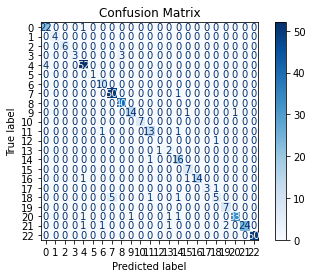

In [60]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot = plot_confusion_matrix(model, # 분류 모델
                             x_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=unique, # 표에 표시할 labels
                             cmap="Blues", # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

In [28]:
conf_df = pd.DataFrame(confusion_matrix(y_predict, y_test), columns = unique)

In [29]:
conf_df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,48,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,56,0,0,...,0,0,0,0,0,2,0,1,0,0
8,0,0,0,2,0,0,0,0,44,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0


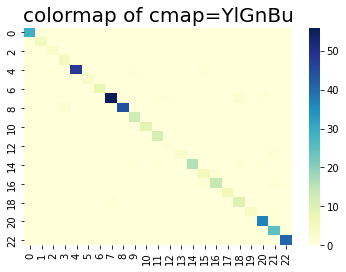

In [30]:
import seaborn as sns

sns.heatmap(conf_df, cmap='YlGnBu') 

plt.title('colormap of cmap=YlGnBu', fontsize=20)

plt.show()

In [61]:
model.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [62]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance')
kn.fit(x_train, y_train)
kn.score(x_test, y_test)

0.916267942583732

In [83]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict, average='macro')

0.8442502420701361

In [84]:
f1_score(y_test, y_predict, average='micro')

0.916267942583732

In [85]:
f1_score(y_test, y_predict, average='weighted')

0.9135555201589022

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

average='weighted'
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average=average)
recall = recall_score(y_test, y_predict, average=average)
f1 = f1_score(y_test, y_predict, average=average)
print('정확도:{}, 정밀도:{}, 재현율:{}, f1_score:{}'.format(accuracy, precision, recall, f1))

정확도:0.916267942583732, 정밀도:0.9205101100086669, 재현율:0.916267942583732, f1_score:0.9135555201589022


In [88]:
kn.save('best_model')

AttributeError: 'KNeighborsClassifier' object has no attribute 'save'

In [35]:
import joblib

In [36]:
joblib.dump(kn, 'knn_model.pkl')

['knn_model.pkl']

In [25]:
def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 


def predict_audio(file_name):
    samples = []
    x, sr = sf.read(file_name, always_2d=True)
    if not len(x) == 0:
        x = parse_audio(x)
        samples.append(mean_mfccs(x))
    else:
        print(file_name)
    return np.array(samples)

In [32]:
x = predict_audio('./AnnotatedAudioFiles/code0_rape_F15_15.wav')

In [33]:
x.shape

(1, 20)

In [34]:
kn.predict(x)

array([3])